In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from xgboost import plot_tree
from matplotlib.pylab import rcParams
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel

In [74]:
%cd /content/drive/My Drive/LolAnalytics

/content/drive/My Drive/LolAnalytics


In [75]:
data = pd.read_csv('high_diamond_ranked_10min.csv')

In [77]:
data.head(5)

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0,15,6,0,6,9,8,0,0,0,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2,12,1,1,5,5,2,2,1,1,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3,15,3,1,11,7,14,0,0,0,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7,15,2,1,5,4,10,0,0,0,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0,17,2,1,6,6,7,1,1,0,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [23]:
data.columns

Index(['gameId', 'blueWins', 'blueWardsPlaced', 'blueWardsDestroyed',
       'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists',
       'blueEliteMonsters', 'blueDragons', 'blueHeralds',
       'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin', 'redWardsPlaced', 'redWardsDestroyed',
       'redFirstBlood', 'redKills', 'redDeaths', 'redAssists',
       'redEliteMonsters', 'redDragons', 'redHeralds', 'redTowersDestroyed',
       'redTotalGold', 'redAvgLevel', 'redTotalExperience',
       'redTotalMinionsKilled', 'redTotalJungleMinionsKilled', 'redGoldDiff',
       'redExperienceDiff', 'redCSPerMin', 'redGoldPerMin'],
      dtype='object')

Some columns in our dataset dont provide additional information(e.g. 'redDeaths' = 'blueKills' so i will delete them)  

In [24]:
cols = ['gameId', 'blueWins', 'blueWardsPlaced', 'blueWardsDestroyed',
       'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists',
       'blueEliteMonsters', 'blueDragons', 'blueHeralds',
       'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin','redWardsPlaced', 'redWardsDestroyed', 'redAssists',
       'redTotalMinionsKilled', 'redTotalJungleMinionsKilled','redCSPerMin', 'redGoldPerMin']
dropped_redundant = data[cols]

In [25]:
dropped_redundant.describe() # checking if any data is missing since it is generated by rito api

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redAssists,redTotalMinionsKilled,redTotalJungleMinionsKilled,redCSPerMin,redGoldPerMin
count,9.879000e+03,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000
mean,4.500084e+09,0.499038,22.288288,2.824881,0.504808,6.183925,6.137666,6.645106,0.549954,0.361980,0.187974,0.051422,16503.455512,6.916004,17928.110133,216.699565,50.509667,14.414111,-33.620306,21.669956,1650.345551,22.367952,2.723150,6.662112,217.349226,51.313088,21.734923,1648.904140
std,2.757328e+07,0.500024,18.019177,2.174998,0.500002,3.011028,2.933818,4.064520,0.625527,0.480597,0.390712,0.244369,1535.446636,0.305146,1200.523764,21.858437,9.898282,2453.349179,1920.370438,2.185844,153.544664,18.457427,2.138356,4.060612,21.911668,10.027885,2.191167,149.088841
min,4.295358e+09,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10730.000000,4.600000,10098.000000,90.000000,0.000000,-10830.000000,-9333.000000,9.000000,1073.000000,6.000000,0.000000,0.000000,107.000000,4.000000,10.700000,1121.200000
25%,4.483301e+09,0.000000,14.000000,1.000000,0.000000,4.000000,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000,15415.500000,6.800000,17168.000000,202.000000,44.000000,-1585.500000,-1290.500000,20.200000,1541.550000,14.000000,1.000000,4.000000,203.000000,44.000000,20.300000,1542.750000
50%,4.510920e+09,0.000000,16.000000,3.000000,1.000000,6.000000,6.000000,6.000000,0.000000,0.000000,0.000000,0.000000,16398.000000,7.000000,17951.000000,218.000000,50.000000,14.000000,-28.000000,21.800000,1639.800000,16.000000,2.000000,6.000000,218.000000,51.000000,21.800000,1637.800000
75%,4.521733e+09,1.000000,20.000000,4.000000,1.000000,8.000000,8.000000,9.000000,1.000000,1.000000,0.000000,0.000000,17459.000000,7.200000,18724.000000,232.000000,56.000000,1596.000000,1212.000000,23.200000,1745.900000,20.000000,4.000000,9.000000,233.000000,57.000000,23.300000,1741.850000
max,4.527991e+09,1.000000,250.000000,27.000000,1.000000,22.000000,22.000000,29.000000,2.000000,1.000000,1.000000,4.000000,23701.000000,8.000000,22224.000000,283.000000,92.000000,11467.000000,8348.000000,28.300000,2370.100000,276.000000,24.000000,28.000000,289.000000,92.000000,28.900000,2273.200000


In [29]:
dropped_redundant.corr() 

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redAssists,redTotalMinionsKilled,redTotalJungleMinionsKilled,redCSPerMin,redGoldPerMin
gameId,1.000000,0.000985,0.005361,-0.012057,-0.011577,-0.038993,-0.013160,-0.023329,0.016599,0.008962,0.015551,-0.007467,-0.033754,-0.040956,-0.040852,-0.002917,-0.004193,-0.014670,-0.012315,-0.002917,-0.033754,0.007405,-0.001197,-0.008664,-0.005118,0.006040,-0.005118,-0.010622
blueWins,0.000985,1.000000,0.000087,0.044247,0.201769,0.337358,-0.339297,0.276685,0.221944,0.213768,0.092385,0.115566,0.417213,0.357820,0.396141,0.224909,0.131445,0.511119,0.489558,0.224909,0.417213,-0.023671,-0.055400,-0.271047,-0.212171,-0.110994,-0.212171,-0.411396
blueWardsPlaced,0.005361,0.000087,1.000000,0.034447,0.003228,0.018138,-0.002612,0.033217,0.019892,0.017676,0.010104,0.009462,0.019725,0.034349,0.031719,-0.033925,0.010501,0.015800,0.027943,-0.033925,0.019725,-0.012906,0.115549,-0.009009,-0.012395,0.001224,-0.012395,-0.005685
blueWardsDestroyed,-0.012057,0.044247,0.034447,1.000000,0.017717,0.033748,-0.073182,0.067793,0.041700,0.040504,0.016940,-0.009150,0.060054,0.060294,0.067462,0.111028,-0.023452,0.078585,0.077946,0.111028,0.060054,0.135966,0.123919,-0.046212,0.040023,-0.035732,0.040023,-0.067467
blueFirstBlood,-0.011577,0.201769,0.003228,0.017717,1.000000,0.269425,-0.247929,0.229485,0.151603,0.134309,0.077509,0.083316,0.312058,0.177617,0.190365,0.125642,0.018190,0.378511,0.240665,0.125642,0.312058,-0.019142,-0.043304,-0.201140,-0.156711,-0.024559,-0.156711,-0.301479
blueKills,-0.038993,0.337358,0.018138,0.033748,0.269425,1.000000,0.004044,0.813667,0.178540,0.170436,0.076195,0.180314,0.888751,0.434867,0.472155,-0.030880,-0.112506,0.654148,0.583730,-0.030880,0.888751,-0.034239,-0.092278,-0.020344,-0.472203,-0.214454,-0.472203,-0.161127
blueDeaths,-0.013160,-0.339297,-0.002612,-0.073182,-0.247929,0.004044,1.000000,-0.026372,-0.204764,-0.188852,-0.095527,-0.071441,-0.162572,-0.414755,-0.460122,-0.468560,-0.228102,-0.640000,-0.577613,-0.468560,-0.162572,0.008102,0.038672,0.804023,-0.040521,-0.100271,-0.040521,0.885728
blueAssists,-0.023329,0.276685,0.033217,0.067793,0.229485,0.813667,-0.026372,1.000000,0.149043,0.170873,0.028434,0.123663,0.748352,0.292661,0.303022,-0.062035,-0.134023,0.549761,0.437002,-0.062035,0.748352,-0.032474,-0.064501,-0.007481,-0.337515,-0.160915,-0.337515,-0.133948
blueEliteMonsters,0.016599,0.221944,0.019892,0.041700,0.151603,0.178540,-0.204764,0.149043,1.000000,0.781039,0.640271,0.166644,0.239396,0.203530,0.232774,0.118762,0.198378,0.281464,0.263991,0.118762,0.239396,-0.017292,-0.005288,-0.156764,-0.074838,-0.087893,-0.074838,-0.216616
blueDragons,0.008962,0.213768,0.017676,0.040504,0.134309,0.170436,-0.188852,0.170873,0.781039,1.000000,0.020381,0.039750,0.186413,0.160683,0.179083,0.086686,0.159595,0.233875,0.211496,0.086686,0.186413,-0.027102,-0.023049,-0.162406,-0.059803,-0.098446,-0.059803,-0.192871


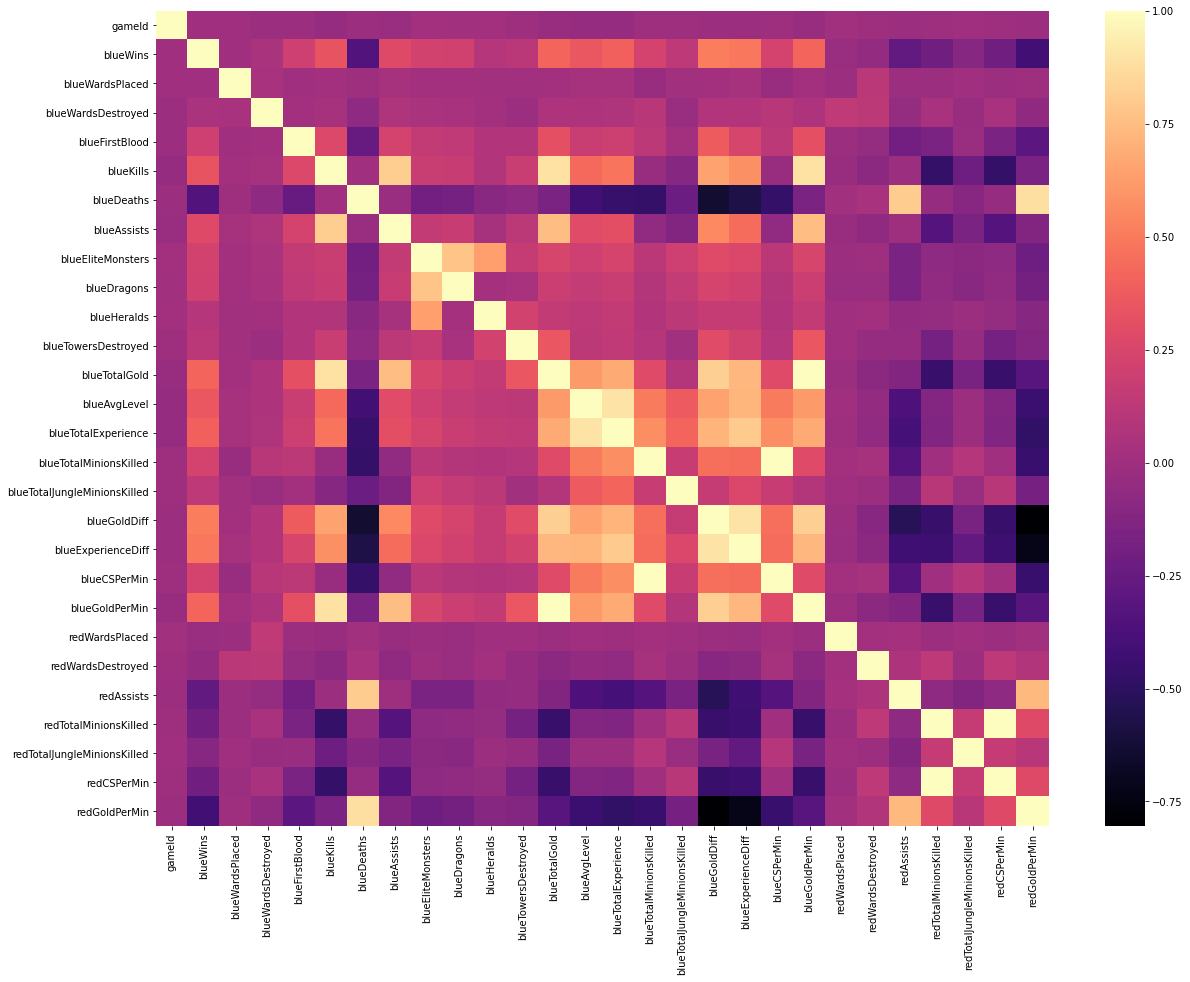

In [35]:
plt.subplots(figsize=(20,15)) # plotting correlation for overview

sns.heatmap(dropped_redundant.corr(), cmap = 'magma')

In [34]:
cols2 =['blueGoldDiff','blueExperienceDiff']
dropped_redundant[cols2].corr()

,blueGoldDiff,blueExperienceDiff
blueGoldDiff,1.000000,0.894729
blueExperienceDiff,0.894729,1.000000


**As we can see in the correlation table, the highest linear dependency with 'blueWins' column have the 'blueGoldDiff' and 'blueExperienceDiff' columns. Lets plot them.**

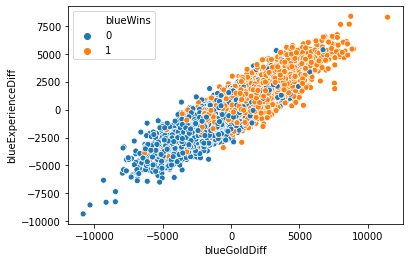

In [28]:
sns.scatterplot(x = 'blueGoldDiff' , y ='blueExperienceDiff', hue ='blueWins',data = dropped_redundant)

As we expected those 2 columns explain most of the variation in the data.

In [78]:
Y = dropped_redundant['blueWins']
X = dropped_redundant.drop(labels = ['blueWins'], axis = 1)

Now lets fit our data to XGboost classifier.

In [127]:
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)

In [138]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Evaluation using train/test split

In [139]:
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 72.19%


Evaluation using 10-fold CV

In [140]:
kfold = KFold(n_splits=10)
results = cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 72.98% (1.31%)


k-fold is generally a better method of evaluation on a small dataset like this since it provides standard deviation and the mean value of the accuracy, as we can see in the example above train/test split probably lowered the true accuracy of the model. Next I plotted a single tree to see what did it take into account while classificating.


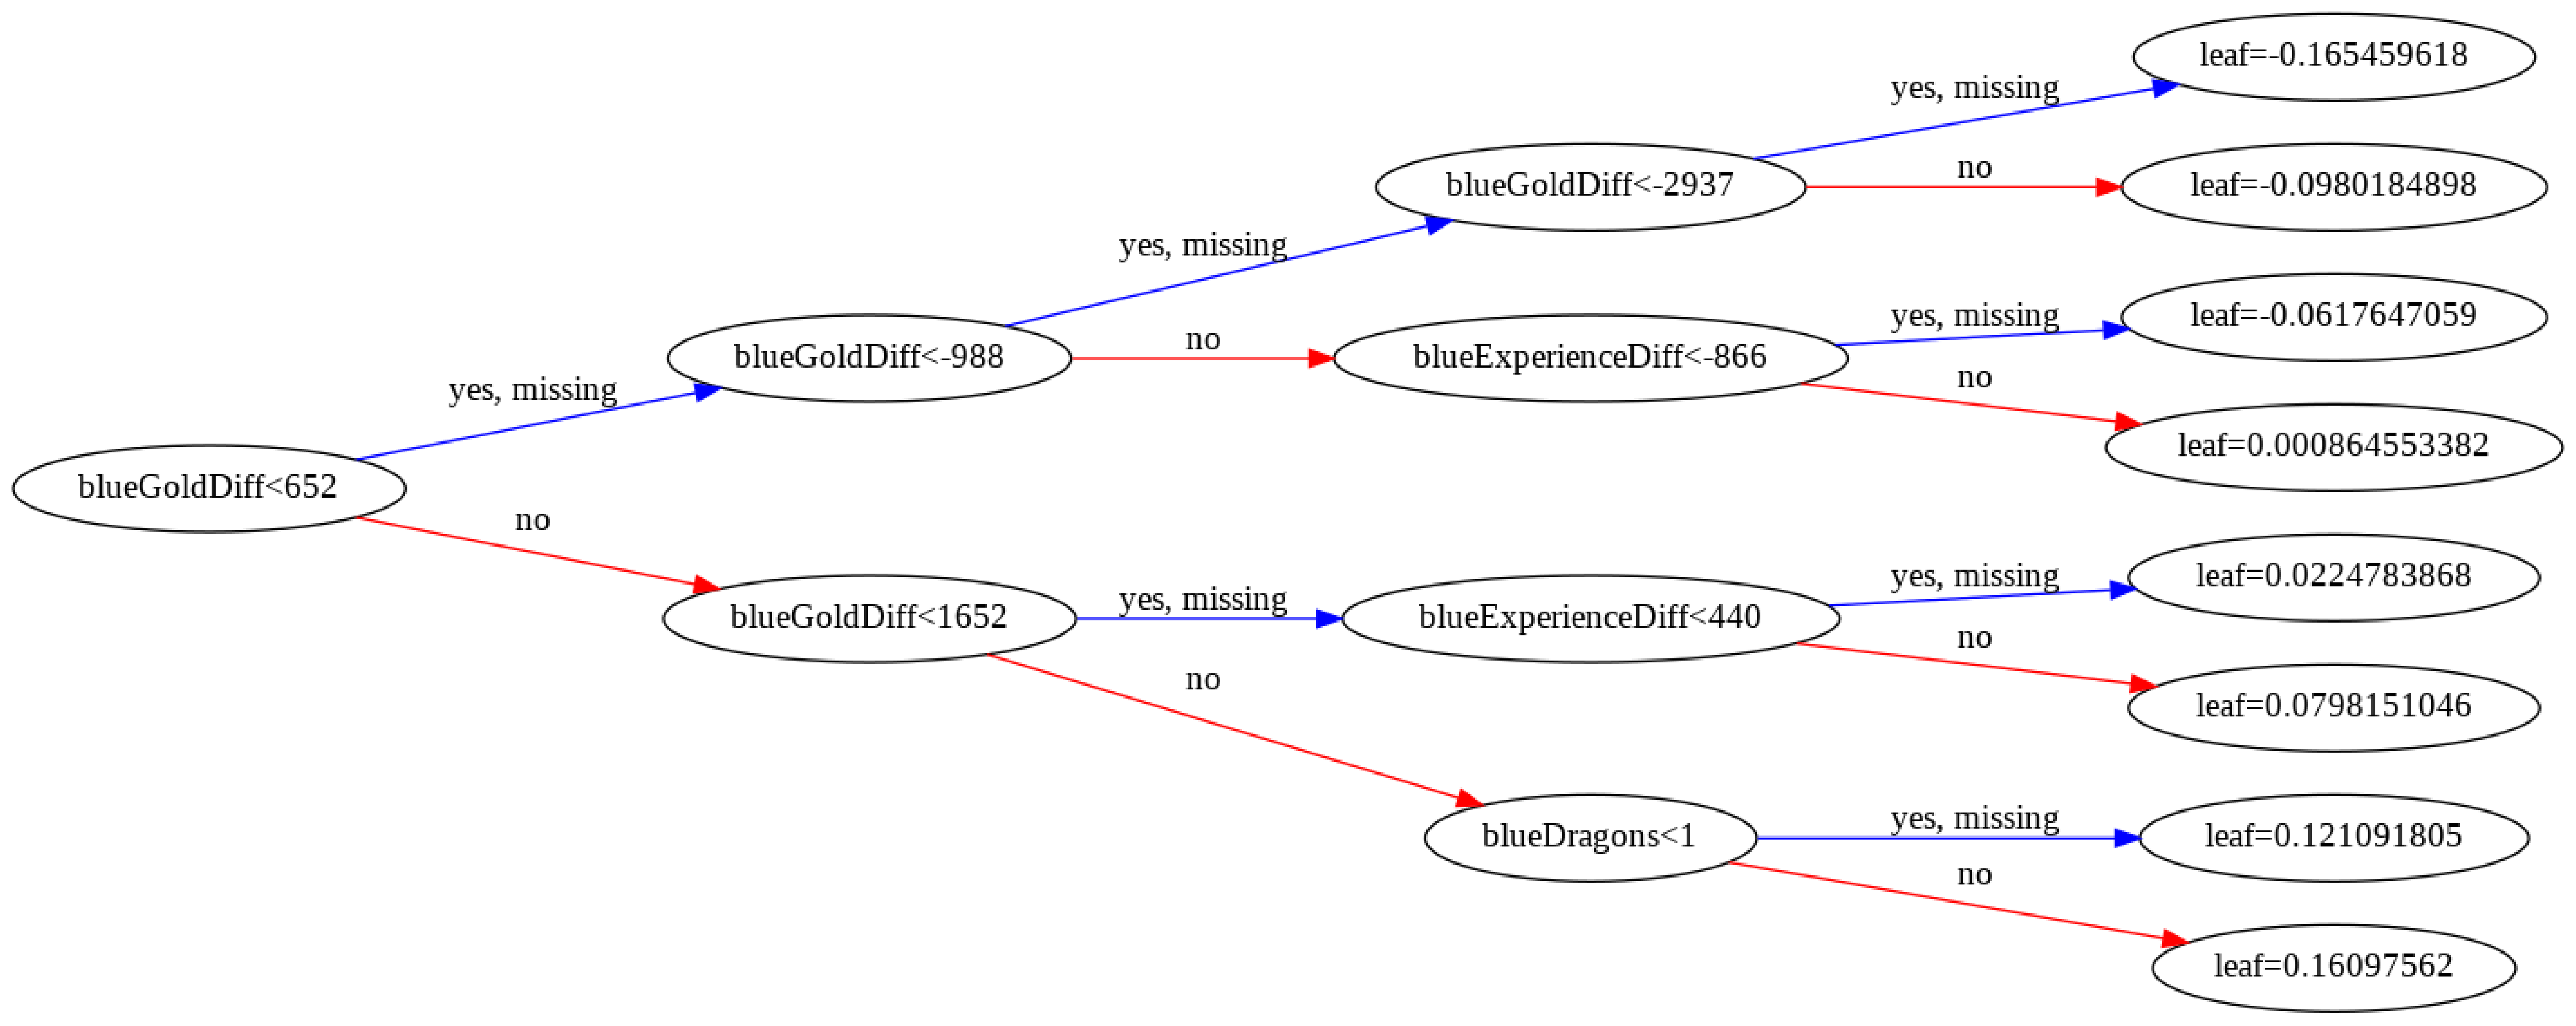

In [141]:
rcParams['figure.figsize'] = 80,50
plot_tree(model1, num_trees=0,rankdir='LR')

Lets check what our model thinks about which features are the most important.

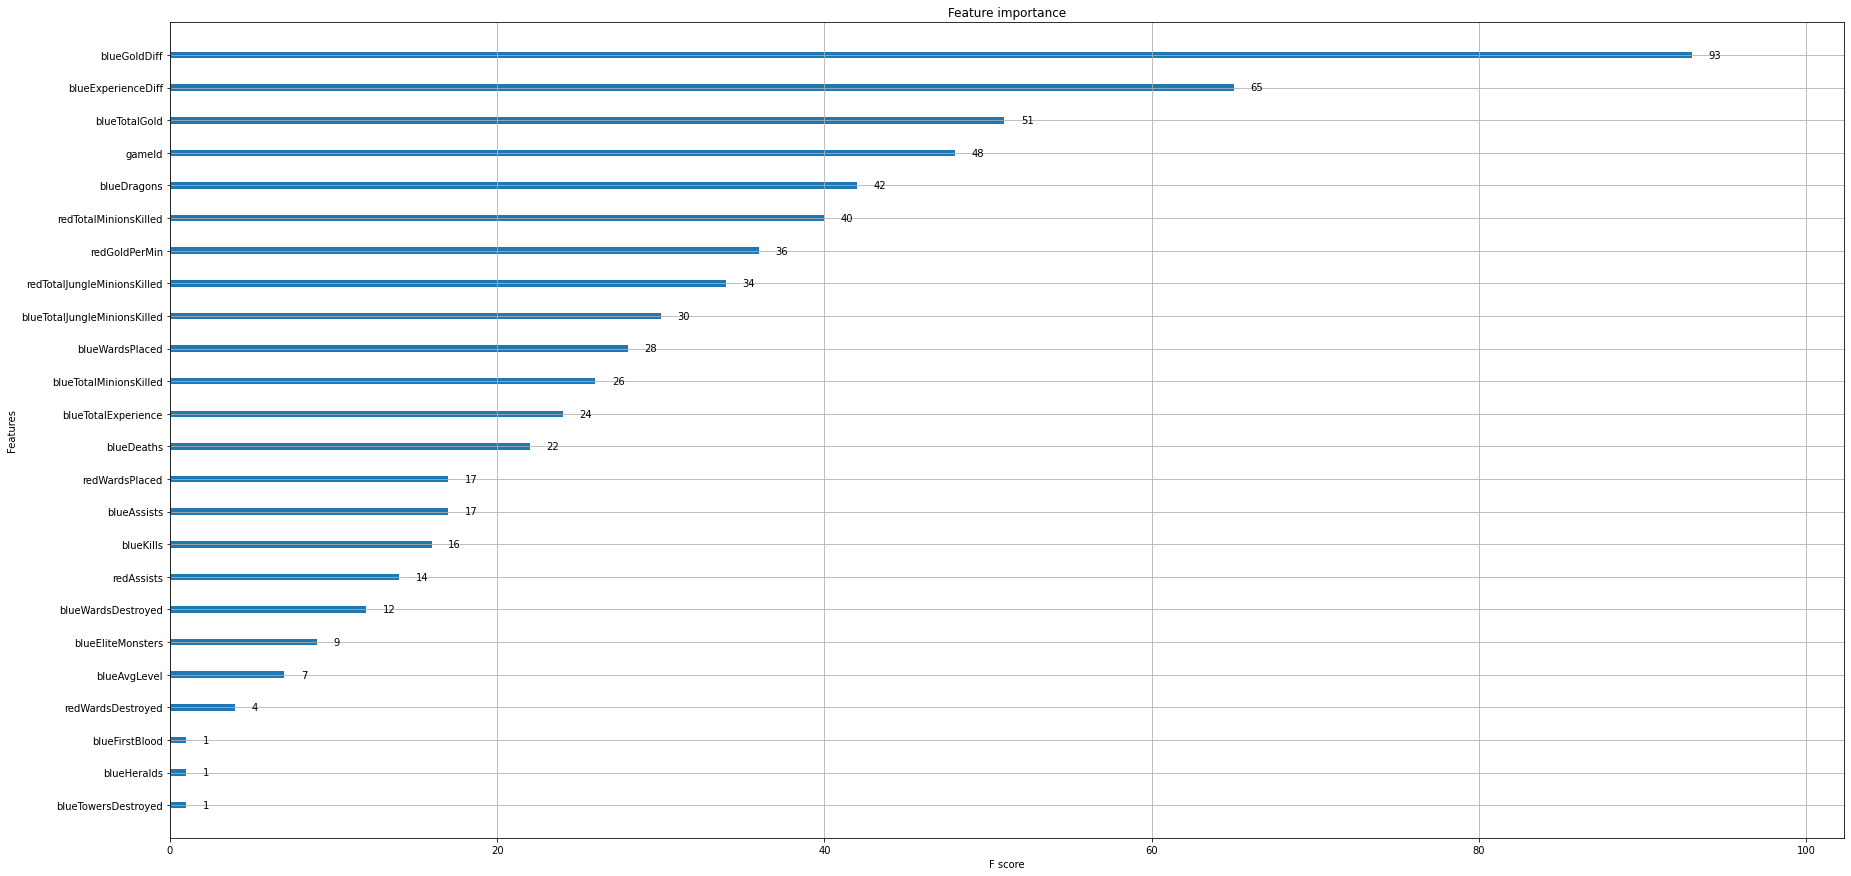

In [142]:
rcParams['figure.figsize'] = 30,15
plot_importance(model1)

As we can see our feature gameid is quite important which might be a sign of overfitting the data. But I will take care of this in the later part of the notebook.

Lets create some predictions and make them into probabilities as this is our main goal

In [144]:
predfeatures = X.sample(n = 20)
predicts = model1.predict_proba(predfeatures)

cols2 = ['probability lose','probability win']
for i,col in enumerate(cols2):
    predfeatures[col] = predicts[:, i]

In [145]:
predfeatures[['blueGoldDiff','blueExperienceDiff']+ cols2].head()

,blueGoldDiff,blueExperienceDiff,probability lose,probability win
7479,572,-233,0.506554,0.493446
1760,1847,1663,0.137590,0.862410
8754,124,-46,0.521278,0.478722
6935,-4379,-3811,0.967640,0.032360
2992,1698,1171,0.193418,0.806582


Possible further improvements of the accuracy:

1.   Team compositions information (scaling/non-scaling composition)
2.   Personal player information (e.g. if any of the players is on lose streak or if any of the players has a winrate > 65% or if he plays his favorite champion)
3.   Feature engineering
4.   Model improvement(e.g. pruning)
5.   Feature selection

We will start from point 4 and try to fit slightly better model. First lets see the training process.

[0]	validation_0-error:0.279843	validation_0-logloss:0.666893	validation_1-error:0.285802	validation_1-logloss:0.667493
[1]	validation_0-error:0.267906	validation_0-logloss:0.645461	validation_1-error:0.270469	validation_1-logloss:0.645983
[2]	validation_0-error:0.268057	validation_0-logloss:0.627575	validation_1-error:0.270469	validation_1-logloss:0.628688
[3]	validation_0-error:0.265941	validation_0-logloss:0.612537	validation_1-error:0.275682	validation_1-logloss:0.613761
[4]	validation_0-error:0.265186	validation_0-logloss:0.600037	validation_1-error:0.269243	validation_1-logloss:0.601315
[5]	validation_0-error:0.266244	validation_0-logloss:0.589445	validation_1-error:0.269243	validation_1-logloss:0.590819
[6]	validation_0-error:0.268359	validation_0-logloss:0.580554	validation_1-error:0.268016	validation_1-logloss:0.581961
[7]	validation_0-error:0.264733	validation_0-logloss:0.572904	validation_1-error:0.269243	validation_1-logloss:0.574556
[8]	validation_0-error:0.264884	validati

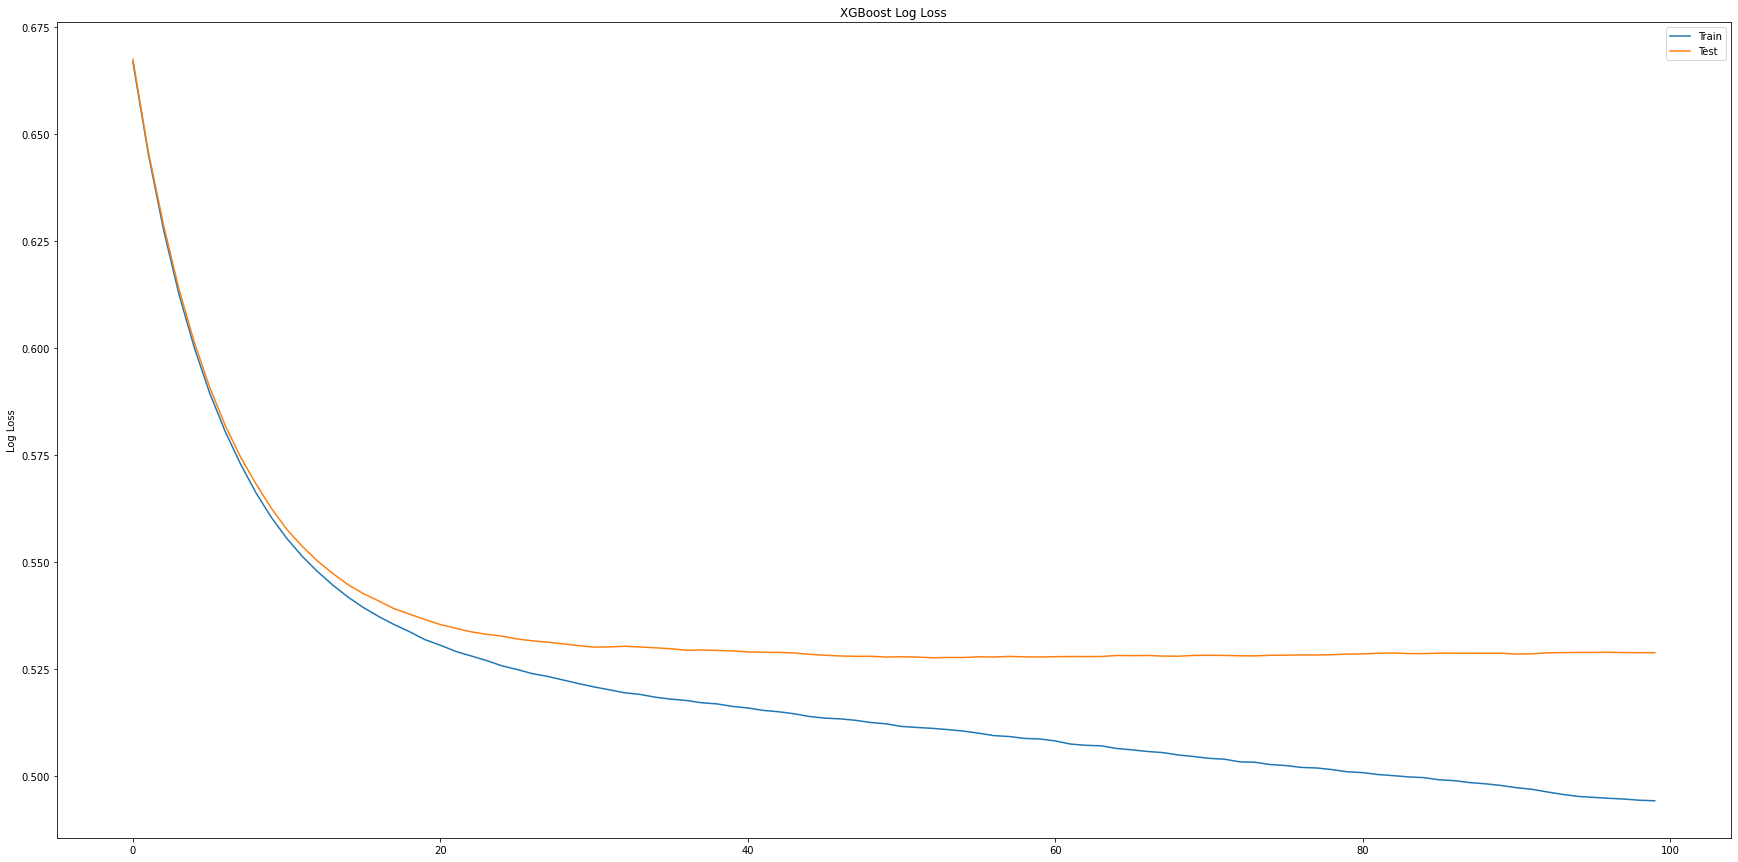

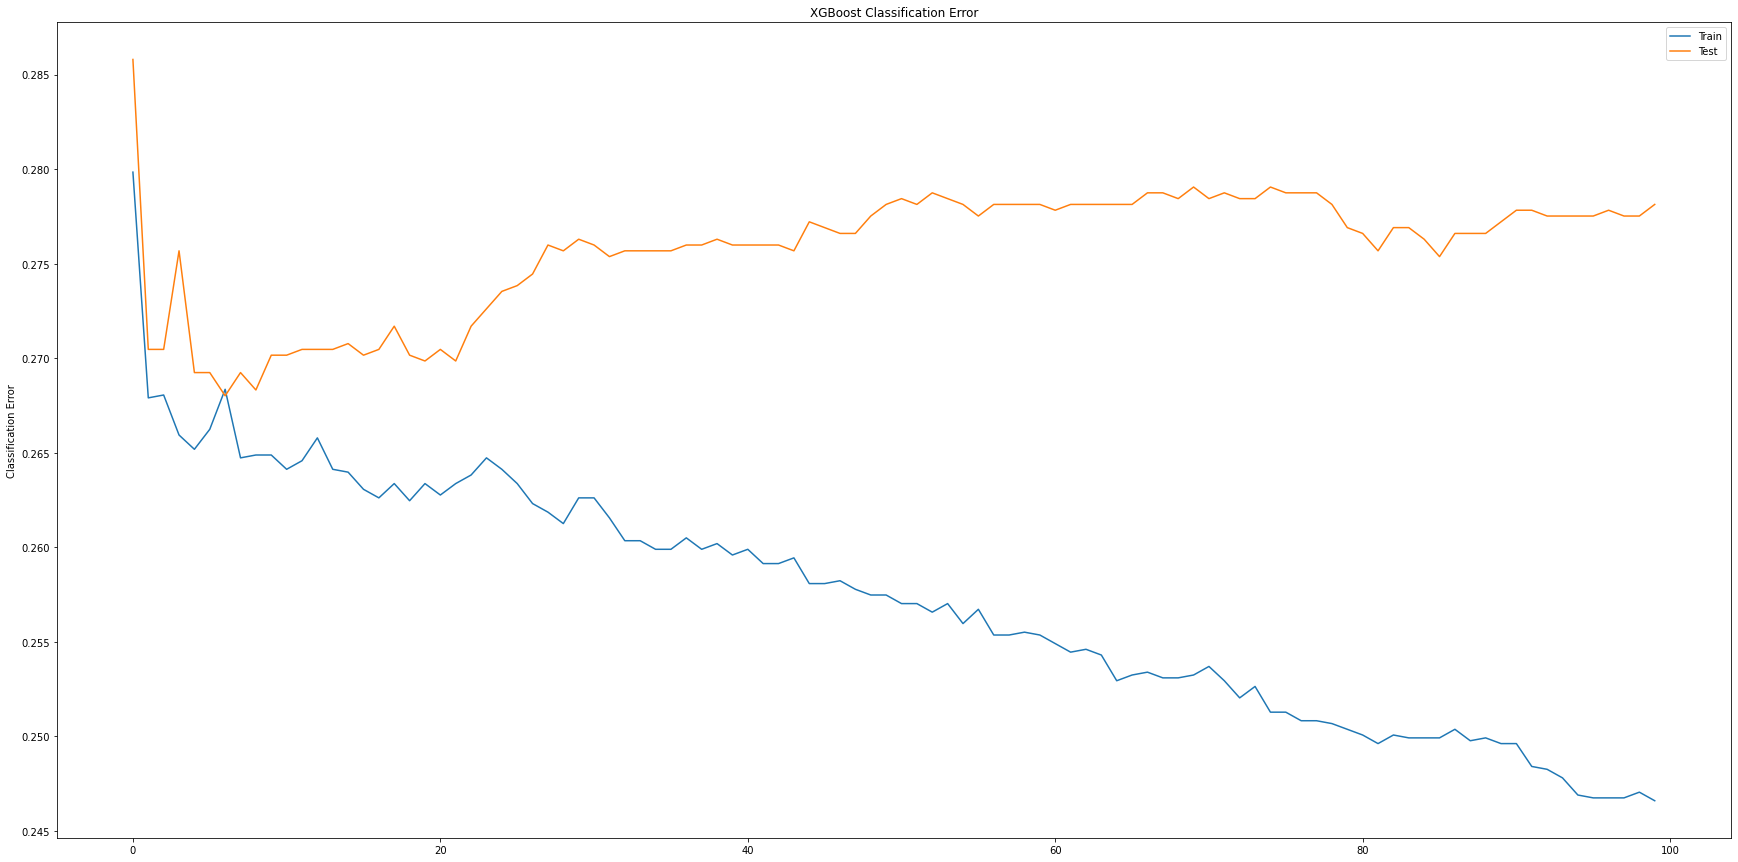

In [153]:
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set,
verbose=True)
# make predictions for test data
predictions = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()


As we can see our training loss is getting smaller but test acc stays the same and even increases which tells us that we are overfitting our model and we should stop our model early.